# Histopathologic Cancer Detection - Mini Project

**Kaggle Competition**: [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

## Problem Description
This challenge is a binary image classification problem where the goal is to detect metastatic cancer in small image patches derived from larger pathology slides. Identifying cancerous cells is crucial for proper diagnosis and treatment planning.

## Data Description
The dataset consists of:
- **Images**: 96x96 color image patches in `.tif` format.
- **Train Labels**: CSV file with two columns: `id` and `label` (1 for cancer, 0 for non-cancer).
- The training set contains over 220,000 images.

---

## Exploratory Data Analysis (EDA)
We will start by inspecting the dataset structure, looking at the distribution of labels, and displaying a few example images to understand what the model will learn from.

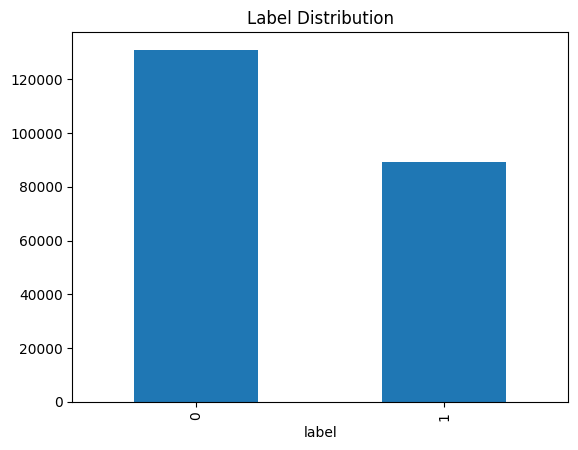

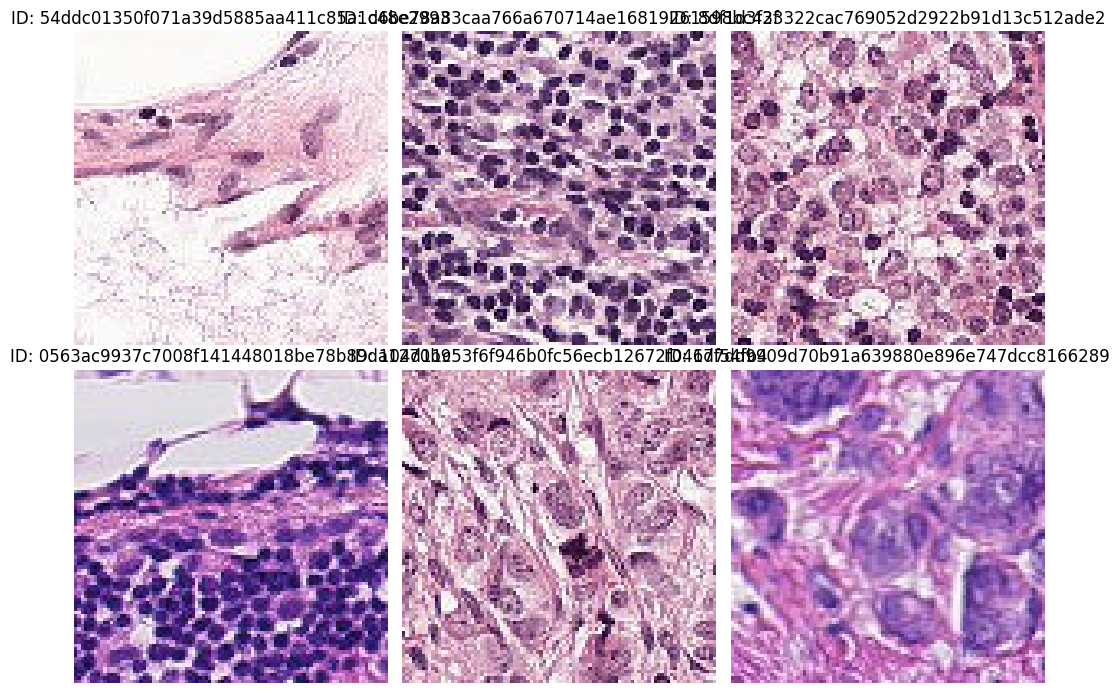

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
import numpy as np

# Load labels
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df['label'].value_counts().plot(kind='bar', title='Label Distribution')
df['label'] = df['label'].astype(str)
plt.show()

# Show a few example images
sample_ids = df.sample(6)['id'].values
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, img_id in zip(axes.flatten(), sample_ids):
    img = Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif')
    ax.imshow(img)
    ax.set_title(f'ID: {img_id}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Pre-Processing

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dir = "/kaggle/input/histopathologic-cancer-detection/train"
df["id"] = df["id"].astype(str) + ".tif"
df["path"] = df["id"].apply(lambda x: os.path.join(image_dir, x))

# Parameters
IMG_SIZE = 96
BATCH_SIZE = 64

# Data Generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='path',
    y_col='label',
    subset='training',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='path',
    y_col='label',
    subset='validation',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture
I will use Convolutional Neural Networks (CNNs) for this task as they are well-suited for image classification problems.

### Baseline Model
A simple CNN with a few Conv2D and MaxPooling2D layers followed by Dense layers.

### Optimized Model
I will use an identical model, and implement the RMSprop optimizer rather than adam.

I will compare model performance mainly using validation accuracy.

## Model Training and Evaluation
We will use early stopping, learning rate scheduling, and model checkpointing during training to prevent overfitting and select the best model.

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745598257.531832      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("baseline_model.keras", save_best_only=True)

baseline_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745598265.187131      94 service.cc:148] XLA service 0x7b6b78009730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745598265.187973      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745598265.486009      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2751 ━━━━━━━━━━━━━━━━━━━━ 6:18:14 8s/step - accuracy: 0.3281 - loss: 0.7229

I0000 00:00:1745598267.985543      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1862s 674ms/step - accuracy: 0.7734 - loss: 0.4866 - val_accuracy: 0.8333 - val_loss: 0.3869
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 566s 205ms/step - accuracy: 0.8286 - loss: 0.3910 - val_accuracy: 0.8389 - val_loss: 0.3745
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 695s 252ms/step - accuracy: 0.8474 - loss: 0.3561 - val_accuracy: 0.8584 - val_loss: 0.3309
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 572s 207ms/step - accuracy: 0.8644 - loss: 0.3153 - val_accuracy: 0.8607 - val_loss: 0.3345
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 494s 179ms/step - accuracy: 0.8798 - loss: 0.2859 - val_accuracy: 0.8677 - val_loss: 0.3259
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 578s 210ms/step - accuracy: 0.8935 - loss: 0.2545 - val_accuracy: 0.8646 - val_loss: 0.3353
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 488s 177ms/step - accuracy: 0.9060 - loss: 0.2291 - val_accuracy: 0.8660 - val_loss: 0.3333
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 405s 147ms/step - accuracy: 0.

## Hyperparameter Tuning
To improve performance, we can experiment with:
- Different optimizers (Adam, RMSprop, SGD)
- Learning rates
- Number of filters and dropout rates

In this case, I will try optimizing with RMSprop, and evaluate the models. Additional improvements may include fine-tuning learning rate, optimizer selection, and augmentations.

In [8]:
from tensorflow.keras.optimizers import RMSprop, SGD

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint("optimized_model.keras", save_best_only=True)
# Update model with RMSprop
print("Compiling model")
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

print("Training optimized model")
optimized_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Compiling model
Training optimized model
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 465s 168ms/step - accuracy: 0.7448 - loss: 0.5202 - val_accuracy: 0.8000 - val_loss: 0.4418
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 414s 150ms/step - accuracy: 0.7992 - loss: 0.4457 - val_accuracy: 0.8058 - val_loss: 0.4254
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 387s 141ms/step - accuracy: 0.8138 - loss: 0.4209 - val_accuracy: 0.8164 - val_loss: 0.4086
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 382s 139ms/step - accuracy: 0.8262 - loss: 0.3952 - val_accuracy: 0.8389 - val_loss: 0.3667
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 377s 137ms/step - accuracy: 0.8374 - loss: 0.3708 - val_accuracy: 0.8500 - val_loss: 0.3464


## Results Visualization
We visualize training and validation accuracy and loss to evaluate overfitting or underfitting.

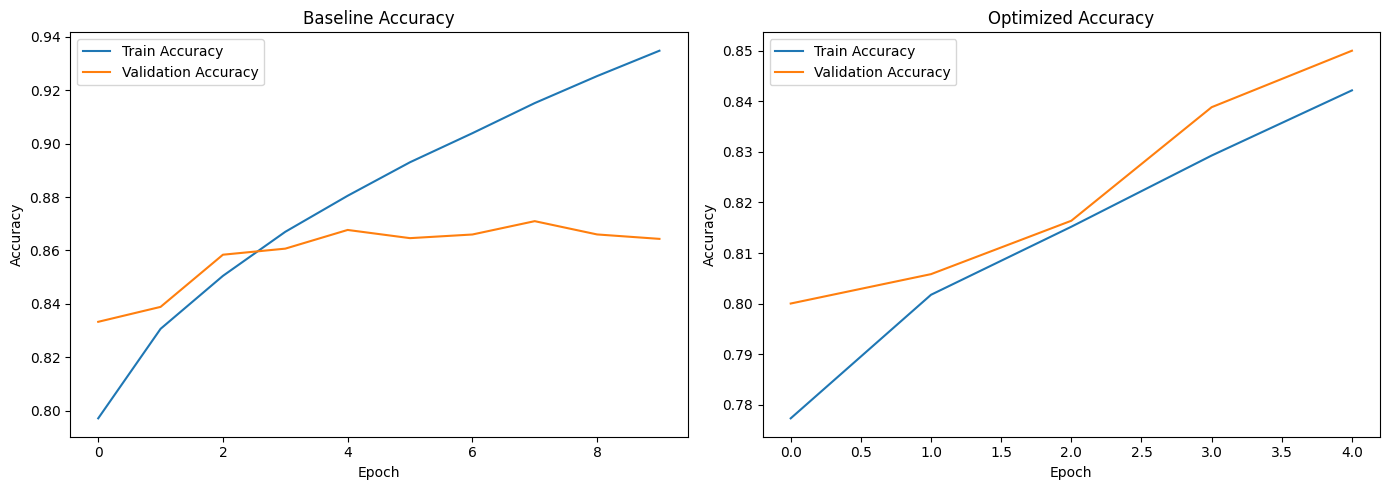

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(optimized_history.history['accuracy'], label='Train Accuracy')
plt.plot(optimized_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Final Results Table
We summarize results using accuracy and loss from the best performing model.

In [10]:
baseline_res = baseline_history.history
optimized_res = optimized_history.history

results_df = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'],
    'Baseline': [baseline_res['accuracy'][-1], baseline_res['val_accuracy'][-1], baseline_res['loss'][-1], baseline_res['val_loss'][-1]],
    'Optimized': [optimized_res['accuracy'][-1], optimized_res['val_accuracy'][-1], optimized_res['loss'][-1], optimized_res['val_loss'][-1]]
})
display(results_df)

,Metric,Baseline,Optimized
0,Train Accuracy,0.934809,0.842194
1,Validation Accuracy,0.864334,0.850040
2,Train Loss,0.167930,0.363977
3,Validation Loss,0.391575,0.346423


## Conclusion
We explored a CNN-based approach to identify cancer in histopathologic images. The baseline model performs reasonably, even surpassing the RMSprop optimized model. I assume the reason for this is that Adam optimizer combines the momentum and RMSprop techniques and in turn provides a more balanced and efficient optimization process. Further improvements can include using advanced techniques such as:
- Transfer learning
- Better augmentation
- Hyperparameter tuning
- Adding more filters

Further exploration can involve using attention-based networks or ensemble models for better accuracy.

## Submission

In [11]:
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# test file names DF
test_files = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')
test_df = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_files],
    'filename': test_files
})

# make test data gen
submission_batch_size = BATCH_SIZE * 2 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/histopathologic-cancer-detection/test',
    x_col='filename',
    y_col=None,  # no labels for test data
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [12]:
# predict
print("\nGenerating predictions for submission...")
optimized_model = tf.keras.models.load_model('/kaggle/working/baseline_model.keras')
predictions = optimized_model.predict(
    test_generator,
    verbose=1
)
predicted_classes = (predictions > 0.5).astype(int).flatten()


Generating predictions for submission...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 535s 596ms/step


In [13]:
# save
submission_df = pd.DataFrame({
    'id': test_df['id'][:len(predicted_classes)],
    'label': predicted_classes
})

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")
print(f"Sample of submission file:\n{submission_df.head()}")

Submission saved to submission.csv
Sample of submission file:
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
